In [4]:
!pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.1/72.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

import cv2
from PIL import Image
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import random
import skimage.io as io

import torch
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pycocotools.coco import COCO
import torchvision.transforms as T

import torchvision.transforms as transforms
from torchsummary import summary

import math

In [18]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download the COCO dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/validation",
#     label_types=["detections"]
#     )

# # Download the COCO training dataset
# dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="train",
#     dataset_dir="/content/drive/MyDrive/COCO_dataset/train",
#     label_types=["detections"],
#     # classes=["person"]
#     max_samples=25000,
# )

### Load and visualize Oxford Town

In [3]:
oxford_annotations = pd.read_csv('/content/drive/MyDrive/Oxford/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
                                'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])
oxford_annotations.head(5)

,personNumber,frameNumber,headNumber,bodyNumber,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627


In [4]:
oxford_video_path = '/content/drive/MyDrive/Oxford/TownCentreXVID.mp4'
output_dir = '/content/drive/MyDrive/Oxford/Images'

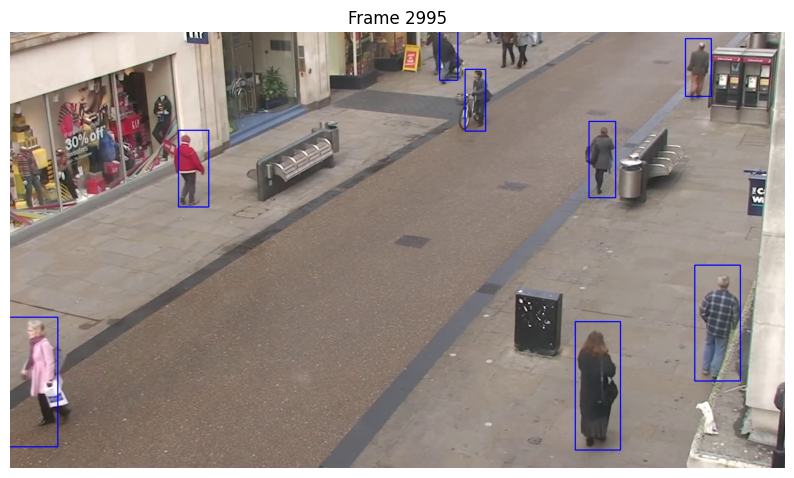

In [5]:
# Function to draw bounding boxes on an image
def draw_bounding_boxes(image, boxes):
    for box in boxes:
        x1 = int(box[0])
        y1 = int(box[1])
        x2 = int(box[2])
        y2 = int(box[3])
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue color bounding box
    return image

# Visualize images with bounding boxes
frames = oxford_annotations['frameNumber'].unique()
frames10 = frames[2995:2996]
for frame in frames10:
    frame = int(frame)
    image_path = os.path.join(output_dir, f'{frame}.jpg')
    image = cv2.imread(image_path)

    if image is not None:
        # Extract bounding box coordinates for the current frame
        boxes = oxford_annotations[oxford_annotations['frameNumber'] == frame][['bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom']].values

        # Draw bounding boxes on the image
        image_with_boxes = draw_bounding_boxes(image, boxes)

        # Convert BGR image to RGB for matplotlib
        image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        # Display the image with bounding boxes
        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title(f'Frame {frame}')
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for frame {frame} not found.")

loading annotations into memory...
Done (t=19.36s)
creating index...
index created!


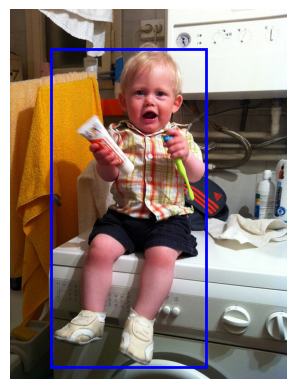

In [6]:
# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"

# Visualize example image
coco = COCO(coco_train_inst_ann_file)
catIds = coco.getCatIds(catNms='person')
imgIds = coco.getImgIds(catIds=catIds)

# Filter images with at least one bounding box annotation
filtered_imgIds = []
for img_id in imgIds:
    annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    anns = coco.loadAnns(annIds)
    if any(ann['bbox'] for ann in anns):
        filtered_imgIds.append(img_id)

# Initialize random image
random_img_id = random.choice(filtered_imgIds)

# Initialize random image
img = coco.loadImgs(random_img_id)[0]

# Load the image
I = io.imread(img['coco_url'])

fig, ax = plt.subplots()
ax.imshow(I)

annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None, catIds=catIds[0])
anns = coco.loadAnns(annIds)

for ann in anns:
    box = ann['bbox']
    bb = patches.Rectangle((box[0], box[1]), box[2], box[3], linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(bb)

plt.axis('off')
plt.show()

In [7]:
def filter_image_ids(img_dir, coco, coco_caps, words):
    # List downloaded images
    downloaded_imgs = set(os.listdir(img_dir))

    # Get image IDs for images containing people
    cat_ids = coco.getCatIds(catNms=['person'])
    img_ids = coco.getImgIds(catIds=cat_ids)

    filtered_img_ids = []
    for img_id in img_ids:
        img_info = coco.loadImgs(img_id)[0]
        img_filename = img_info['file_name']
        if img_filename in downloaded_imgs:
            ann_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
            anns = coco.loadAnns(ann_ids)
            if any(ann['bbox'] for ann in anns):
                cap_ids = coco_caps.getAnnIds(imgIds=img_id)
                caps = coco_caps.loadAnns(cap_ids)
                for cap in caps:
                    caption = cap['caption'].lower()
                    if any(word in caption for word in words):
                        filtered_img_ids.append(img_id)
                        break

    print(f"Found {len(filtered_img_ids)} images matching criteria.")
    return filtered_img_ids

In [8]:
def resize_with_padding(image, target_size):
    # Resize while maintaining aspect ratio
    image.thumbnail((target_size, target_size), Image.LANCZOS)
    # Create a new image with the target size and paste the resized image
    new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
    new_image.paste(image, ((target_size - image.width) // 2, (target_size - image.height) // 2))
    return new_image


# Define transformations
augmentations = T.Compose([
    T.RandomHorizontalFlip(),  # randomly flip horizontally
    T.RandomRotation(10),  # randomly rotate by 10 degrees
    T.RandomAffine(0, shear=10, scale=(0.8, 1.2)),  # random affine transformations
])

# Define the combined transformation for training data
train_transform = T.Compose([
    T.Lambda(lambda img: resize_with_padding(img, 512)),
    augmentations,
    T.ToTensor(),  # transform to tensor, brings pixels to range (0, 1)
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))  # normalize to range (-1, 1) for all three channels
])

# For validation, we only resize and convert to tensor
val_transform = T.Compose([
    T.Lambda(lambda img: resize_with_padding(img, 512)),
    T.ToTensor(),
    T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])


In [9]:
class CocoCountDataset(Dataset):
    def __init__(self, img_dir, coco, coco_caps, img_ids, transform=None, max_samples=None):
        self.img_dir = img_dir
        self.coco = coco
        self.coco_caps = coco_caps
        self.transform = transform

        if max_samples:
            self.img_ids = img_ids[:max_samples]
        else:
            self.img_ids = img_ids

        if not self.img_ids:
            raise ValueError("No valid images found after filtering non-existing files.")

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        image = Image.open(img_path).convert("RGB")
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.coco.getCatIds(catNms=['person']), iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        count = len(anns)  # Number of people in the image

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)


In [10]:
# Paths to annotation files
coco_train_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/instances_train2017.json"
coco_train_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/train/raw/captions_train2017.json"
coco_val_inst_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/instances_val2017.json"
coco_val_caps_ann_file = "/content/drive/MyDrive/COCO_dataset/validation/raw/captions_val2017.json"

# Directory paths
train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/data'
val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'

# Words to filter in captions
words = ['street', 'road', 'city', 'surveillance', 'people']

# Initialize COCO objects
coco_train = COCO(coco_train_inst_ann_file)
coco_train_caps = COCO(coco_train_caps_ann_file)
coco_val = COCO(coco_val_inst_ann_file)
coco_val_caps = COCO(coco_val_caps_ann_file)

# Filter image IDs
train_img_ids = filter_image_ids(train_img_dir, coco_train, coco_train_caps, words)
val_img_ids = filter_image_ids(val_img_dir, coco_val, coco_val_caps, words)

# Define max_samples (optional)
# max_samples = 2000

try:
    coco_train_dataset = CocoCountDataset(
        img_dir=train_img_dir,
        coco=coco_train,
        coco_caps=coco_train_caps,
        img_ids=train_img_ids,
        transform=train_transform,
        # max_samples=max_samples  # Use max_samples if defined, otherwise it will be None
    )
    print(f"Number of training images: {len(coco_train_dataset)}")

    coco_val_dataset = CocoCountDataset(
        img_dir=val_img_dir,
        coco=coco_val,
        coco_caps=coco_val_caps,
        img_ids=val_img_ids,
        transform=val_transform,
        # max_samples=max_samples  # Use max_samples if defined, otherwise it will be None
    )
    print(f"Number of validation images: {len(coco_val_dataset)}")

except ValueError as e:
    print(e)

loading annotations into memory...
Done (t=22.94s)
creating index...
index created!
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.48s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
Found 5224 images matching criteria.
Found 1071 images matching criteria.
Number of training images: 5224
Number of validation images: 1071


In [ ]:
# import os

# train_img_dir = '/content/drive/MyDrive/COCO_dataset/train/train/data'
# val_img_dir = '/content/drive/MyDrive/COCO_dataset/validation/validation/data'

# # Check if directories are accessible
# try:
#     train_files = os.listdir(train_img_dir)
#     print(f"Number of files in train directory: {len(train_files)}")
# except Exception as e:
#     print(f"Error accessing train directory: {e}")

# try:
#     val_files = os.listdir(val_img_dir)
#     print(f"Number of files in validation directory: {len(val_files)}")
# except Exception as e:
#     print(f"Error accessing validation directory: {e}")


In [11]:
# data = pd.read_csv('/content/drive/My Drive/Oxford/TownCentre-groundtruth.top', names= ['personNumber', 'frameNumber',
#                                 'headNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'headBottom', 'bodyLeft', 'bodyTop', 'bodyRight', 'bodyBottom'])

data = oxford_annotations.drop(['headNumber','personNumber', 'bodyNumber', 'headLeft', 'headTop', 'headRight', 'bodyLeft',
                  'bodyTop','bodyRight','bodyBottom','headBottom'], axis='columns')

count_data = data.drop_duplicates(subset='frameNumber', keep='first')

frame_counts = data['frameNumber'].value_counts(sort = False).reset_index()
frame_counts.columns = ['frameNumber', 'count']

count_data = count_data.merge(frame_counts, on='frameNumber')

# Split the data into training and validation sets
train_frame_counts, val_frame_counts = train_test_split(count_data, test_size=0.2, random_state=42)

In [12]:
class oxfordDataset(Dataset):
    def __init__(self, data_dir, frame_counts, transform=None):
        self.data_dir = data_dir
        self.data = frame_counts
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_info = self.data.iloc[idx]
        img_filename = f"{img_info['frameNumber']}.jpg"  # Assuming image filenames are like '0000.jpg', '0001.jpg', etc.
        img_path = os.path.join(self.data_dir, img_filename)
        image = Image.open(img_path).convert("RGB")
        count = img_info['count']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(count, dtype=torch.float32)

In [ ]:
# def resize_with_padding(image, target_size):
#     # Resize while maintaining aspect ratio
#     image.thumbnail((target_size, target_size), Image.LANCZOS)
#     # Create a new image with the target size and paste the resized image
#     new_image = Image.new("RGB", (target_size, target_size), (0, 0, 0))
#     new_image.paste(image, ((target_size - image.width) // 2, (target_size - image.height) // 2))
#     return new_image

In [ ]:
# transform = T.Compose([
#     T.Lambda(lambda img: resize_with_padding(img, 512)),
#     T.ToTensor(),
# ])

In [13]:
# Initialize the second dataset
ox_img = '/content/drive/MyDrive/Oxford/Images'

# Initialize the second datasets
ox_train_dataset = oxfordDataset(data_dir=ox_img, frame_counts=train_frame_counts, transform=train_transform)
ox_val_dataset = oxfordDataset(data_dir=ox_img, frame_counts=val_frame_counts, transform=val_transform)

# Combine datasets
train_combined_dataset = ConcatDataset([coco_train_dataset, ox_train_dataset])
val_combined_dataset = ConcatDataset([coco_val_dataset, ox_val_dataset])

# Create data loaders
train_loader = DataLoader(train_combined_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_combined_dataset, batch_size=16, shuffle=False)

In [14]:
# Check the lengths of individual datasets
print(f"Length of COCO train dataset: {len(coco_train_dataset)}")
print(f"Length of Oxford train dataset: {len(ox_train_dataset)}")

# Check the length of the combined dataset
print(f"Length of Combined train dataset: {len(train_combined_dataset)}")

Length of COCO train dataset: 5224
Length of Oxford train dataset: 2472
Length of Combined train dataset: 7696


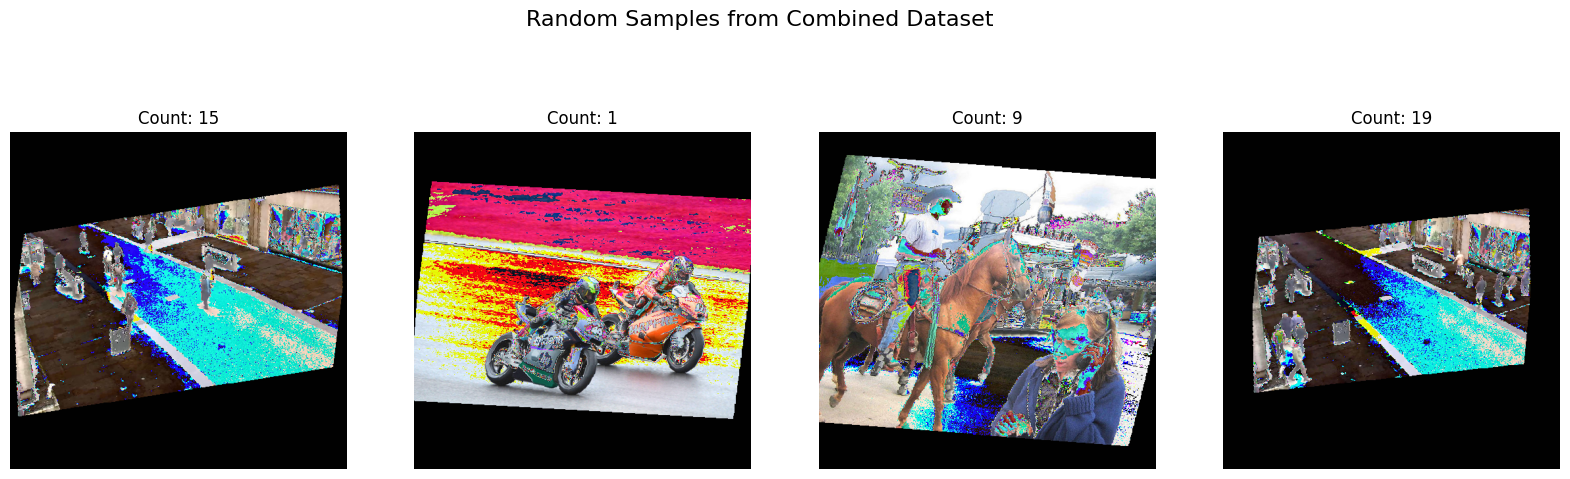

In [15]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import torchvision.transforms as T

def visualize_random_samples(dataset, num_samples=5):
    # Get a list of indices
    indices = random.sample(range(len(dataset)), num_samples)

    # Set up the figure and axes
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 6))
    fig.suptitle('Random Samples from Combined Dataset', fontsize=16)

    for i, idx in enumerate(indices):
        img, count = dataset[idx]

        # Convert tensor to PIL image for visualization
        img = T.ToPILImage()(img)

        # Plot image
        ax = axes[i]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Count: {int(count.item())}')

    plt.show()

# Visualize random samples from the combined training dataset
visualize_random_samples(train_combined_dataset, num_samples=4)

# Optionally visualize random samples from the combined validation dataset
# visualize_random_samples(val_combined_dataset, num_samples=5)


In [16]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')

In [27]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# Adjust the number of filters
class CNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNN, self).__init__()
        self.in_channels = 32  # Reduce the initial number of channels

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the model
cnn_model = CNN(BasicBlock, [2, 2, 2, 2]).to(device)
summary(cnn_model, input_size=(3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             864
       BatchNorm2d-2         [-1, 32, 512, 512]              64
              ReLU-3         [-1, 32, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           4,608
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
            Conv2d-7         [-1, 32, 512, 512]           4,608
       BatchNorm2d-8         [-1, 32, 512, 512]              64
              ReLU-9         [-1, 32, 512, 512]               0
       BasicBlock-10         [-1, 32, 512, 512]               0
           Conv2d-11         [-1, 16, 512, 512]           4,608
      BatchNorm2d-12         [-1, 16, 512, 512]              32
             ReLU-13         [-1, 16, 512, 512]               0
           Conv2d-14         [-1, 32, 5

In [28]:
def train_cnn_model(epochs, model, optimizer, criterion, train_loader, val_loader, early_stopper):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]

            optimizer.zero_grad()
            output = model(data)  # Get the model output
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                target = target.view(-1, 1)  # Reshape target to be [batch_size, 1]
                output = model(data)  # Get the model output
                loss = criterion(output, target)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss / len(train_loader):.4f}, Validation Loss: {val_loss / len(val_loader):.4f}')

        # Early stopping call and pass the model for checkpointing
        early_stopper(val_loss / len(val_loader), model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses


In [29]:
# set hyperparameters
epochs = 20
patience = 5
lr = 0.0005
reg = 0.0001

criterion = nn.MSELoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=lr, weight_decay=reg)
early_stopper = EarlyStopping(patience=patience)

# training the model
train_losses, val_losses = train_cnn_model(epochs, cnn_model, cnn_optimizer, criterion, train_loader, val_loader, early_stopper)

# plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

KeyboardInterrupt: 

In [ ]:
def evaluate_model(data_loader, model):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_preds = []

    # Collect all labels and model outputs
    with torch.no_grad():
        for images, count in data_loader:
            images, count = images.to(device), count.to(device)
            output = model(images)
            y_preds.extend(output.cpu().numpy())
            y_true.extend(count.cpu().numpy())

    mae = mean_absolute_error(y_true, y_preds)
    mse = mean_squared_error(y_true, y_preds)
    r2 = r2_score(y_true, y_preds)

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    return mae, mse, r2

Validation Loss: 14.9787


In [ ]:
def visualize_prediction(model, dataset, number_of_images):
    model.eval()

    random_indices = random.sample(range(len(dataset)), number_of_images)

    # Calculate grid size
    rows = math.ceil(number_of_images / 4)
    cols = min(4, number_of_images)

    fig, axes = plt.subplots(rows, cols, figsize=(12, 3 * rows))  # Adjust figure size based on rows
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, idx in enumerate(random_indices):
        image, true_count = dataset[idx]
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(device)
            predicted_count, _ = model(image_tensor)
            predicted_count = torch.round(predicted_count).item()  # Round and convert to scalar
            image_np = image.cpu().numpy().transpose(1, 2, 0)
            image_np = image_np * 0.5 + 0.5

            if rows == 1 and cols == 1:
                ax = axes
            elif rows == 1 or cols == 1:
                ax = axes[i]
            else:
                ax = axes[i // cols, i % cols]

            ax.imshow(image_np)
            ax.set_title(f"True: {int(true_count)}, Predicted: {int(predicted_count)}")
            ax.axis('off')

    plt.show()

# Visualize the prediction for the first image in the validation set
visualize_prediction(cnn_model, val_combined_dataset, number_of_images=16)